In [1]:
# import abc
from abc import ABC, abstractmethod
from collections import OrderedDict
import random
import pandas as pd

In [58]:
class Sack:
    def __init__(self):
        self.chips = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1

    def ziehen(self):
        index = random.randint(0,len(self.chips)-1)
        return self.chips.pop(index)

    def stopfen(self, chip):
        self.chips.append(chip)

moneros = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,15,16,16,17,17,18,18,19,19,20,20,21,21,22,22,23,23,24,24,25,25,26,26,27,27,28,28,29,29,30,30,31,31,32,32,33,33]
rubinis = [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
siegis =  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9,10,10,10,11,11,11,12,12,12,12,13,13,13,14,14]
print(len(moneros))
print(len(rubinis))

class Player():
    def __init__(self, name):
        self.name = name
        self.sack = Sack()
        self.kessel = Kessel(self.sack)

        self.siegis = 0
        self.rubinis = 0
        self.moneros = 0

    def stop_condition(self):
        return not self.kessel.exploded

    def runde(self):
        while self.stop_condition():
            self.kessel.brauen()

        earned_siegis, earned_moneros, earned_rubinis = self.kessel.wertung()

        self.siegis += earned_siegis
        self.moneros += earned_moneros
        self.rubinis += earned_rubinis



        # TODO: implement using moneros to buy chips
        assert self.moneros >= 3, "Not enough moneros to buy a this strategy"

        if self.moneros - OrangeChip(1).cost >= 16:
            self.sack.chips.append(RedChip(4))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 10:
            self.sack.chips.append(RedChip(2))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 6:
            self.sack.chips.append(RedChip(1))
            self.sack.chips.append(OrangeChip(1))
        elif self.moneros - OrangeChip(1).cost >= 3:
            self.sack.chips.append(RedChip(1))


        # Prepare for next round
        for chip in self.kessel.values():
            self.sack.stopfen(chip)

        self.moneros = 0
        self.kessel.clear()

        self.kessel.exploded = False

class Schisser(Player):
    def stop_condition(self):
        return max([chip.value for chip in self.sack.chips if isinstance(chip, KnallChip)]) + self.kessel.getSumOfKind(KnallChip) < self.kessel.explosion_threshold

class Kessel(OrderedDict):
    def __init__(self, sack:Sack) -> None:
        self.sack = sack
        self.exploded = False
        self.explosion_threshold = 8

    def brauen(self):
        chip = self.sack.ziehen()
        chip.played(self)
        # TODO: check if previous board modifies position further (in a way not specific to chip)

        if chip.knallerbse:
            if self.getSumOfKind(KnallChip) >= self.explosion_threshold:
                #print("BOOM")
                self.exploded = True

    def wertung(self):
        # TODO: implement getting rubins for green chip at last 2 spots
        #print(green_in_last_two, [chip for chip in list(self.values())[-2:]])

        # TODO: implement getting siegis/rubins/drops for purple

        eval_number = self.getCurrenPosition()+1
        if eval_number >= len(siegis):
            eval_number = len(siegis)-1

        earned_siegis  = siegis[eval_number]
        earned_moneros = moneros[eval_number]
        earned_rubinis = rubinis[eval_number]

        green_in_last_two = [chip for chip in list(self.values())[-2:] if isinstance(chip, GreenChip)]
        if len(green_in_last_two) > 0:
            earned_rubinis += 1

        return earned_siegis, earned_moneros, earned_rubinis

    def getCurrenPosition(self):
        if len(self) == 0:
            return 0
        return next(reversed(self))

    def getNumberOfKind(self, kind):
        return len([x for x in self.values() if isinstance(x, kind)])

    def getSumOfKind(self, kind):
        return sum([x.value for x in self.values() if isinstance(x, kind)])

class Chip:
    def __init__(self, value, knallerbse=False):
        self.value = value
        self.knallerbse = knallerbse

    def __repr__(self) -> str:
        return str(self.__class__.__name__) + "(" +str(self.value)+")"

    def played(self, kessel:Kessel):
        position = kessel.getCurrenPosition() + self.value
        kessel[position] = self

class RedChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  6),
                                (2, 10),
                                (4, 16)])
        self.cost = costs[value]

    def played(self, kessel:Kessel):
        additional = 0
        n_orange = kessel.getNumberOfKind(OrangeChip)
        if n_orange > 0:
            additional = 1
        elif n_orange > 2:
            additional = 2
        position = kessel.getCurrenPosition() + self.value + additional
        kessel[position] = self

class OrangeChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  3),])
        self.cost = costs[value]

class GreenChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  4),
                                (2,  8),
                                (4, 14)])
        self.cost = costs[value]

class YellowChip(Chip):
    def __init__(self, value, knallerbse=False):
        super().__init__(value, knallerbse)

        costs = OrderedDict([   (1,  8),
                                (2, 12),
                                (4, 18)])
        self.cost = costs[value]

    def played(self, kessel: Kessel):
        super().played(kessel)
        if isinstance(kessel[kessel.getCurrenPosition()], KnallChip):
            del kessel[kessel.getCurrenPosition()]

class BlueChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([   (1,  5),
                                (2, 10),
                                (4, 19)])
        self.cost = costs[value]

    def played(self, kessel: Kessel):
        super().played(kessel)

        options = [kessel.sack.ziehen() for i in range(self.value)]
        choice_index = int(input("Choose one of the following chips by index: " + str(options)))

        if choice_index == -1:                      # choose not to play anything
            pass
        elif choice_index >= 0 and choice_index < len(options):
            options[choice_index].played(kessel)    # play the chip
            del options[choice_index]               # remove the chip from the options
        else:
            raise ValueError("Invalid choice")
        for option in options:
            kessel.sack.stopfen(option)

class PurpleChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=False)

        costs = OrderedDict([(1,  9)])
        self.cost = costs[value]

class KnallChip(Chip):
    def __init__(self, value):
        super().__init__(value, knallerbse=True)

    def played(self, kessel:Kessel):
        return super().played(kessel)


initial_content = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1

p1 = Player("Player1")

for i in range(3):
    p1.kessel.brauen()
    print(p1.kessel)

p1.sack.chips.append(YellowChip(1))
print('added yellow chip in sack')

p1.sack.chips.append(RedChip(1))
print('added red chip in sack')

#sack1.chips.append(BlueChip(1))
#print('added blue chip in sack')

for i in range(6):
    p1.kessel.brauen()
    print(p1.kessel)

print(p1.kessel)

53
53
Kessel([(2, KnallChip(2))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1))])
added yellow chip in sack
added red chip in sack
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1)), (8, KnallChip(3))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1)), (8, KnallChip(3)), (10, KnallChip(2))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1)), (8, KnallChip(3)), (10, KnallChip(2)), (11, GreenChip(1))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1)), (8, KnallChip(3)), (10, KnallChip(2)), (11, GreenChip(1)), (12, OrangeChip(1))])
Kessel([(2, KnallChip(2)), (3, KnallChip(1)), (4, KnallChip(1)), (5, KnallChip(1)), (8, KnallChip(3)), (10, KnallChip(2)), (11, GreenChip(1)), (12, OrangeChip(1)), (13, KnallChip(1))

In [59]:
example_ordered_dict = OrderedDict([(1, 1), (2, 2), (3, 3)])
example_ordered_dict[6] = 4
example_ordered_dict.clear()
example_ordered_dict

OrderedDict()

<Axes: title={'center': 'Strategy: Pyrotechnician-isst-Kürbis-Pilssuppe'}, ylabel='Frequency'>

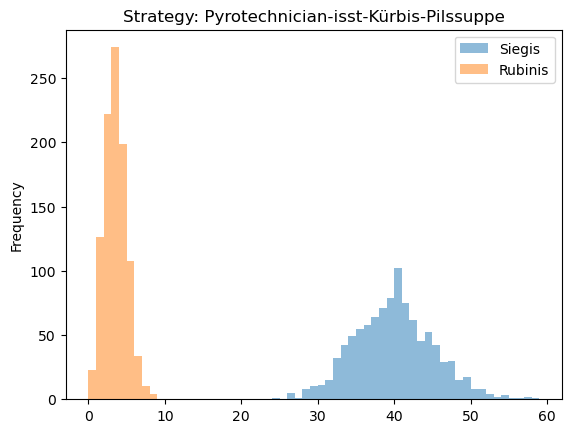

In [63]:
n_simulations = 1000
n_rounds = 9

wertungen = []

strategy_name = "Pyrotechnician-isst-Kürbis-Pilssuppe"

for i in range(n_simulations):

    player = Player(strategy_name + "_" + str(i))

    for j in range(n_rounds):
        player.runde()

        wertungen.append([i, j, player.siegis, player.moneros, player.rubinis])

wertungen = pd.DataFrame(wertungen, columns=["Simulation", "Round", "Siegis", "Moneros", "Rubinis"])

wertungen[wertungen['Round'] == n_rounds-1][['Siegis', 'Rubinis']].plot.hist(bins=range(0, 60), alpha=0.5, title="Strategy: " + strategy_name )


<Axes: title={'center': 'Strategy: Schisser-isst-Kürbis-Pilssuppe'}, ylabel='Frequency'>

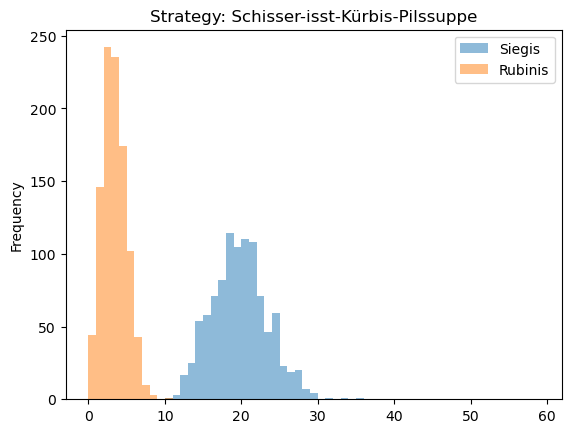

In [61]:
n_simulations = 1000
n_rounds = 9

wertungen = []

strategy_name = "Schisser-isst-Kürbis-Pilssuppe"

for i in range(n_simulations):

    player = Schisser(strategy_name + "_" + str(i))

    for j in range(n_rounds):
        player.runde()

        wertungen.append([i, j, player.siegis, player.moneros, player.rubinis])

wertungen = pd.DataFrame(wertungen, columns=["Simulation", "Round", "Siegis", "Moneros", "Rubinis"])

wertungen[wertungen['Round'] == n_rounds-1][['Siegis', 'Rubinis']].plot.hist(bins=range(0, 60), alpha=0.5, title="Strategy: " + strategy_name )


In [64]:
player.sack.chips

[KnallChip(1),
 OrangeChip(1),
 OrangeChip(1),
 RedChip(4),
 GreenChip(1),
 OrangeChip(1),
 RedChip(2),
 RedChip(2),
 OrangeChip(1),
 RedChip(1),
 RedChip(2),
 OrangeChip(1),
 RedChip(2),
 KnallChip(1),
 RedChip(2),
 OrangeChip(1),
 RedChip(1),
 OrangeChip(1),
 KnallChip(1),
 OrangeChip(1),
 RedChip(4),
 OrangeChip(1),
 KnallChip(2),
 OrangeChip(1),
 KnallChip(2),
 KnallChip(1),
 KnallChip(3)]

In [5]:
wertungen

,Simulation,Round,Siegis,Moneros,Rubinis
0,0,0,2,10,0
1,0,1,4,21,0
2,1,0,1,9,1
3,1,1,3,20,1
4,2,0,2,13,1
...,...,...,...,...,...
1995,997,1,4,22,0
1996,998,0,2,12,1
1997,998,1,3,21,2
1998,999,0,2,11,0


In [6]:
n_simulations = 10

wertungen = []

for i in range(n_simulations):

    player = Player(strategy_name + "_" + str(i))






wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


TypeError: no numeric data to plot

In [ ]:
n_simulations = 10000

wertungen = []

for i in range(n_simulations):
    initial_content = [KnallChip(1)]*4 + [KnallChip(2)]*2 + [KnallChip(3)]*1+ [OrangeChip(1)]*1 + [GreenChip(1)]*1
    sack = Sack(initial_content)
    kessel = Kessel(sack)


    while max([chip.value for chip in sack.chips if isinstance(chip, KnallChip)]) + kessel.getSumOfKind(KnallChip) < kessel.explosion_threshold:
        kessel.brauen()

    kessel.wertung()

    #print(f"Simulation {i+1}: {kessel.siegis} Siegis, {kessel.moneros} Moneros, {kessel.rubinis} Rubinis")
    wertungen.append([kessel.siegis, kessel.moneros, kessel.rubinis])

wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


TypeError: Sack.__init__() takes 1 positional argument but 2 were given

In [ ]:
n_simulations = 10
n_rounds = 2

wertungen = []

for i in range(n_simulations):

    player = Player(strategy_name + "_" + str(i))


    for i in range(n_rounds):

        player.runde()



wertungen = pd.DataFrame(wertungen, columns=["Siegis", "Moneros", "Rubinis"])

wertungen.plot.hist(bins=range(0, 20), alpha=0.5, title="Strategy: Schisser")


TypeError: no numeric data to plot